# Continuous renal replacement therapy (CRRT)

This notebook overviews the process of defining CRRT: a treatment used to dialyse or filter a patient's blood continuously. Key to CRRT is its lower speed compared to conventional dialysis: avoidance of rapid solute/fluid loss is suspected to be the main reason why CRRT tends to be tolerated better than intermittent hemodialysis.

The primary aim of this notebook is to define the start and end times of CRRT for patients in the MIMIC-III database v1.4.

A secondary aim of this notebook is to provide insight into how to extract clinical concepts from the MIMIC-III database.

Many thanks to Sharon O'Donoghue for her invaluable advice in the creation of this notebook.

## Outline

The main steps in defining a clinical concept in MIMIC-III are as follows:

1. Identification of key terms and phrases which describe the concept
2. Search for these terms in D_ITEMS (or D_LABITEMS if searching for a laboratory measurement)
3. Extraction of the data from tables specified in the `LINKSTO` column of D_ITEMS
4. Definition of the concept using rules applied to the data extracted
5. Validation of the concepts by individual inspection and aggregate statistics

This process is iterative and not as clear cut as the above - validation may lead you to redefine data extraction, and so on. Furthermore, in the case of MIMIC-III v1.4, this process must be repeated twice: once for Metavision, once for CareVue.

## MetaVision vs. CareVue

One issue in MIMIC-III is that it is a combination of two ICU database systems. As a result, concepts are split among different `ITEMID` values. For example, a patient's heart rate is a relatively simple concept to extract, however, if we look in the D_ITEMS table for labels matching 'heart rate', we find at least two `ITEMID`:

itemid |          label          |  abbreviation   |  dbsource  |   linksto
--------|-------------------------|-----------------|------------|-------------
211 | Heart Rate              |                 | carevue    | chartevents
220045 | Heart Rate              | HR              | metavision | chartevents

Both these `ITEMID` values capture heart rate - but one is used for the CareVue database system (`dbsource = 'carevue'`) and one is used for the MetaVision database system (`dbsource = 'metavision'`). The data extraction step must be repeated twice: once for `dbsource = 'carevue'` and once for `dbsource = 'metavision'`. In general, it is recommended to extract data from MetaVision first, as the data is better structured and provides useful information for what data elements to include. For example, `ITEMID` values in MetaVision have abbrevations with each label - these abbreviations can then be used to search for data elements in CareVue.

# Step 0: import libraries, connect to the database

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
from IPython.display import display, HTML # used to print out pretty pandas dataframes
import matplotlib.dates as dates
import matplotlib.lines as mlines

%matplotlib inline
plt.style.use('ggplot') 

# specify user/password/where the database is
sqluser = 'postgres'
sqlpass = 'postgres'
dbname = 'mimic'
schema_name = 'mimiciii'
host = 'localhost'

query_schema = 'SET search_path to ' + schema_name + ';'

# connect to the database
con = psycopg2.connect(dbname=dbname, user=sqluser, password=sqlpass, host=host)

# Step 1: Identification of key terms

We are interested in continuous renal replacement therapy (CRRT). First, we look for 'CRRT' in the database, isolating ourselves to metavision data:

In [2]:


query = query_schema + """
select itemid, label, category, linksto
from d_items
where dbsource = 'metavision'
and lower(label) like '%crrt%'
"""
df = pd.read_sql_query(query,con)

df

,itemid,label,category,linksto
0,227290,CRRT mode,Dialysis,chartevents
1,225436,CRRT Filter Change,Dialysis,procedureevents_mv
2,227525,Calcium Gluconate (CRRT),Medications,inputevents_mv
3,225802,Dialysis - CRRT,Dialysis,procedureevents_mv
4,227536,KCl (CRRT),Medications,inputevents_mv
5,225956,Reason for CRRT Filter Change,Dialysis,chartevents


The above gives us some hints to expand our initial search:

* `category = 'Dialysis'`
* `lower(label) like '%dialysis%'`


# Step 2: Extraction of `ITEMID`s from tables

## Get list of `itemid` related to CRRT

In [3]:
query = query_schema + """
select itemid, label, category, linksto
from d_items di
where dbsource = 'metavision'
and (lower(label) like '%dialy%'
or category = 'Dialysis'
or lower(label) like '%crrt%'
)
order by linksto, category, label
"""
df = pd.read_sql_query(query,con)

HTML(df.head().to_html().replace('NaN', ''))

,itemid,label,category,linksto
0,225740,Dialysis Catheter Discontinued,Access Lines - Invasive,chartevents
1,227357,Dialysis Catheter Dressing Occlusive,Access Lines - Invasive,chartevents
2,225776,Dialysis Catheter Dressing Type,Access Lines - Invasive,chartevents
3,226118,Dialysis Catheter placed in outside facility,Access Lines - Invasive,chartevents
4,227753,Dialysis Catheter Placement Confirmed by X-ray,Access Lines - Invasive,chartevents


## Manually label above `itemid`

The above is a list of all the potential data elements which could be used to define CRRT. The next step is to identify the specific elements which can be used to define start/stop time. This process requires clinical expertise in the area.

The following tables are a result of reviewing all `ITEMID` labels and flagging them as "consider for further review" or "not relevant".


### Links to CHARTEVENTS

itemid | label | category | linksto | Included/comment
--- | --- | --- | --- | ---
225740 | Dialysis Catheter Discontinued | Access Lines - Invasive | chartevents | No - access line
227357 | Dialysis Catheter Dressing Occlusive | Access Lines - Invasive | chartevents | No - access line
225776 | Dialysis Catheter Dressing Type | Access Lines - Invasive | chartevents | No - access line
226118 | Dialysis Catheter placed in outside facility | Access Lines - Invasive | chartevents | No - access line
227753 | Dialysis Catheter Placement Confirmed by X-ray | Access Lines - Invasive | chartevents | No - access line
225323 | Dialysis Catheter Site Appear | Access Lines - Invasive | chartevents | No - access line
225725 | Dialysis Catheter Tip Cultured | Access Lines - Invasive | chartevents | No - access line
227124 | Dialysis Catheter Type | Access Lines - Invasive | chartevents | No - access line
225126 | Dialysis patient | Adm History/FHPA | chartevents | No - admission information
224149 | Access Pressure | Dialysis | chartevents | Yes - CRRT setting
224404 | ART Lumen Volume | Dialysis | chartevents | Yes - CRRT setting
224144 | Blood Flow (ml/min) | Dialysis | chartevents | Yes - CRRT setting
228004 | Citrate (ACD-A) | Dialysis | chartevents | Yes - CRRT setting
227290 | CRRT mode | Dialysis | chartevents | Yes - CRRT setting
225183 | Current Goal | Dialysis | chartevents | Yes - CRRT setting
225977 | Dialysate Fluid | Dialysis | chartevents | Yes - CRRT setting
224154 | Dialysate Rate | Dialysis | chartevents | Yes - CRRT setting
224135 | Dialysis Access Site | Dialysis | chartevents | No - access line
225954 | Dialysis Access Type | Dialysis | chartevents | No - access line
224139 | Dialysis Site Appearance | Dialysis | chartevents | No - access line
225810 | Dwell Time (Peritoneal Dialysis) | Dialysis | chartevents | No - peritoneal dialysis
224151 | Effluent Pressure | Dialysis | chartevents | Yes - CRRT setting
224150 | Filter Pressure | Dialysis | chartevents | Yes - CRRT setting
226499 | Hemodialysis Output | Dialysis | chartevents | No - hemodialysis
225958 | Heparin Concentration (units/mL) | Dialysis | chartevents | Yes - CRRT setting
224145 | Heparin Dose (per hour) | Dialysis | chartevents | Yes - CRRT setting
224191 | Hourly Patient Fluid Removal | Dialysis | chartevents | Yes - CRRT setting
225952 | Medication Added #1 (Peritoneal Dialysis) | Dialysis | chartevents | No - peritoneal dialysis
227638 | Medication Added #2 (Peritoneal Dialysis) | Dialysis | chartevents | No - peritoneal dialysis
225959 | Medication Added Amount #1 (Peritoneal Dialysis) | Dialysis | chartevents | No - peritoneal dialysis
227639 | Medication Added Amount #2 (Peritoneal Dialysis) | Dialysis | chartevents | No - peritoneal dialysis
225961 | Medication Added Units #1 (Peritoneal Dialysis) | Dialysis | chartevents | No - peritoneal dialysis
227640 | Medication Added Units #2 (Peritoneal Dialysis) | Dialysis | chartevents | No - peritoneal dialysis
228005 | PBP (Prefilter) Replacement Rate | Dialysis | chartevents | Yes - CRRT setting
225965 | Peritoneal Dialysis Catheter Status | Dialysis | chartevents | No - peritoneal dialysis
225963 | Peritoneal Dialysis Catheter Type | Dialysis | chartevents | No - peritoneal dialysis
225951 | Peritoneal Dialysis Fluid Appearance | Dialysis | chartevents | No - peritoneal dialysis
228006 | Post Filter Replacement Rate | Dialysis | chartevents | Yes - CRRT setting
225956 | Reason for CRRT Filter Change | Dialysis | chartevents | Yes - CRRT setting
225976 | Replacement Fluid | Dialysis | chartevents | Yes - CRRT setting
224153 | Replacement Rate | Dialysis | chartevents | Yes - CRRT setting
224152 | Return Pressure | Dialysis | chartevents | Yes - CRRT setting
225953 | Solution (Peritoneal Dialysis) | Dialysis | chartevents | No - peritoneal dialysis
224146 | System Integrity | Dialysis | chartevents | Yes - CRRT setting
226457 | Ultrafiltrate Output | Dialysis | chartevents | Yes - CRRT setting
224406 | VEN Lumen Volume | Dialysis | chartevents | Yes - CRRT setting
225806 | Volume In (PD) | Dialysis | chartevents | No - peritoneal dialysis
227438 | Volume not removed | Dialysis | chartevents | No - peritoneal dialysis
225807 | Volume Out (PD) | Dialysis | chartevents | No - peritoneal dialysis

### Links to DATETIMEEVENTS

itemid | label | category | linksto | Included/comment
--- | --- | --- | --- | ---
225318 | Dialysis Catheter Cap Change | Access Lines - Invasive | datetimeevents | No - access lines
225319 | Dialysis Catheter Change over Wire Date | Access Lines - Invasive | datetimeevents | No - access lines
225321 | Dialysis Catheter Dressing Change | Access Lines - Invasive | datetimeevents | No - access lines
225322 | Dialysis Catheter Insertion Date | Access Lines - Invasive | datetimeevents | No - access lines
225324 | Dialysis CatheterTubing Change | Access Lines - Invasive | datetimeevents | No - access lines
225128 | Last dialysis | Adm History/FHPA | datetimeevents | No - admission information

### Links to INPUTEVENTS_MV

itemid | label | category | linksto | Included/comment
--- | --- | --- | --- | ---
227525 | Calcium Gluconate (CRRT) | Medications | inputevents_mv | Yes - CRRT setting
227536 | KCl (CRRT) | Medications | inputevents_mv | Yes - CRRT setting

### Links to PROCEDUREEVENTS_MV

itemid | label | category | linksto | Included/comment
--- | --- | --- | --- | ---
225441 | Hemodialysis | 4-Procedures | procedureevents_mv | No - hemodialysis
224270 | Dialysis Catheter | Access Lines - Invasive | procedureevents_mv | No - access lines
225436 | CRRT Filter Change | Dialysis | procedureevents_mv | Yes - CRRT setting
225802 | Dialysis - CRRT | Dialysis | procedureevents_mv | Yes - CRRT setting
225803 | Dialysis - CVVHD | Dialysis | procedureevents_mv | Yes - CRRT setting
225809 | Dialysis - CVVHDF | Dialysis | procedureevents_mv | Yes - CRRT setting
225955 | Dialysis - SCUF | Dialysis | procedureevents_mv | Yes - CRRT setting
225805 | Peritoneal Dialysis | Dialysis | procedureevents_mv | No - peritoneal dialysis

## Reasons for inclusion/exclusion

* CRRT Setting - yes (included) - these settings are only documented when a patient is receiving CRRT.
* Access lines- no (excluded) - these ITEMIDs are not included as the presence of an access line does *not* guarantee that CRRT is being delivered. While having an access line is a requirement of performing CRRT, these lines are present even when a patient is not actively being hemodialysed.
* Peritoneal dialysis - no (excluded) - Peritoneal dialysis is a different form of dialysis, and is not CRRT
* Hemodialysis - no (excluded) - Similar as above, hemodialysis is a different form of dialysis and is not CRRT

## Define rules based upon ITEMIDs

Above, we acquired a list of `itemid` which we determined to be related to administration of CRRT. The next step is to determine *how* these `itemid` relate to CRRT: do they indicate it is started, stopped, continuing, or something else.

We will evaluate `itemid` from three tables, in turn: CHARTEVENTS, INPUTEVENTS_MV, and PROCEDUREEVENTS_MV. Note that the \_MV subscript indicates that the table only has data from MetaVision (half the patients), while \_CV indicates the table only has data from CareVue (the other half of patients). Note that after we extract data from MetaVision patients, we will repeat this exercise for CareVue patients.

### table 1 of 3: `itemid` from CHARTEVENTS

These are the included CRRT settings in CHARTEVENTS:

itemid |              label               | param_type 
--------|----------------------------------|------------
224144 | Blood Flow (ml/min)              | Numeric
224145 | Heparin Dose (per hour)          | Numeric
224146 | System Integrity                 | Text
224149 | Access Pressure                  | Numeric
224150 | Filter Pressure                  | Numeric
224151 | Effluent Pressure                | Numeric
224152 | Return Pressure                  | Numeric
224153 | Replacement Rate                 | Numeric
224154 | Dialysate Rate                   | Numeric
224191 | Hourly Patient Fluid Removal     | Numeric
224404 | ART Lumen Volume                 | Numeric
224406 | VEN Lumen Volume                 | Numeric
225183 | Current Goal                     | Numeric
225956 | Reason for CRRT Filter Change    | Text
225958 | Heparin Concentration (units/mL) | Text
225976 | Replacement Fluid                | Text
225977 | Dialysate Fluid                  | Text
226457 | Ultrafiltrate Output             | Numeric
227290 | CRRT mode                        | Text
228004 | Citrate (ACD-A)                  | Numeric
228005 | PBP (Prefilter) Replacement Rate | Numeric
228006 | Post Filter Replacement Rate     | Numeric

First, we examine the numeric fields. These fields are the core CRRT settings which, according to clinical advice, should be documented hourly for patients actively on CRRT:

In [4]:
query = query_schema + """
select
  ce.icustay_id, di.label, ce.charttime
  , ce.value
  , ce.valueuom
from chartevents ce
inner join d_items di
on ce.itemid = di.itemid
where ce.icustay_id = 246866
and ce.itemid in
(
        224404, -- | ART Lumen Volume
        224406, -- | VEN Lumen Volume
        228004, -- | Citrate (ACD-A)
        224145, -- | Heparin Dose (per hour)
        225183, -- | Current Goal
        224149, -- | Access Pressure
        224144, -- | Blood Flow (ml/min)
        224154, -- | Dialysate Rate
        224151, -- | Effluent Pressure
        224150, -- | Filter Pressure
        224191, -- | Hourly Patient Fluid Removal
        228005, -- | PBP (Prefilter) Replacement Rate
        228006, -- | Post Filter Replacement Rate
        224153, -- | Replacement Rate
        224152, -- | Return Pressure
        226457  -- | Ultrafiltrate Output
)
order by ce.icustay_id, ce.charttime, di.label;
"""
df = pd.read_sql_query(query,con)

HTML(df.head().to_html().replace('NaN', ''))

,icustay_id,label,charttime,value,valueuom
0,246866,ART Lumen Volume,2161-12-11 20:00:00,1.3,mL
1,246866,VEN Lumen Volume,2161-12-11 20:00:00,1.2,mL
2,246866,Access Pressure,2161-12-11 23:43:00,-87,mmHg
3,246866,Blood Flow (ml/min),2161-12-11 23:43:00,200,ml/min
4,246866,Citrate (ACD-A),2161-12-11 23:43:00,0,ml/hr


Above we can see that `ART Lumen Volume and VEN Lumen Volume` are documented at a drastically different time than the other settings. Upon discussion with a clinical expert, they confirmed that this is expected, as these volumes indicate settings to keep open the line and are not directly relevant to the administration of CRRT - at best they are superfluous and at worst they can mislead the start/stop times. As a result `ART Lumen Volume` and `VEN Lumen Volume` are excluded. This leaves us with the final set of `ITEMID`s:

```sql
224149, -- Access Pressure
224144, -- Blood Flow (ml/min)
228004, -- Citrate (ACD-A)
225183, -- Current Goal
224154, -- Dialysate Rate
224151, -- Effluent Pressure
224150, -- Filter Pressure
224145, -- Heparin Dose (per hour)
224191, -- Hourly Patient Fluid Removal
228005, -- PBP (Prefilter) Replacement Rate
228006, -- Post Filter Replacement Rate
224153, -- Replacement Rate
224152, -- Return Pressure
226457  -- Ultrafiltrate Output
```

The next step is to examine the remaining text based `ITEMID`:



itemid |              label               | param_type 
--------|----------------------------------|------------
224146 | System Integrity                 | Text
225956 | Reason for CRRT Filter Change    | Text
225958 | Heparin Concentration (units/mL) | Text
225976 | Replacement Fluid                | Text
225977 | Dialysate Fluid                  | Text
227290 | CRRT mode                        | Text

We define a helper function which prints out the number of observations for a given `itemid`:

In [5]:
def print_itemid_info(con, itemid):
    # get name of itemid
    query = query_schema + """
    select label
    from d_items
    where itemid = """ + str(itemid)
    
    df = pd.read_sql_query(query,con)
    print('Values for {} - {}...'.format(itemid, df['label'][0]))
    
    
    query = query_schema + """
    select value
    , count(distinct icustay_id) as number_of_patients
    , count(icustay_id) as number_of_observations
    from chartevents
    where itemid = """ + str(itemid) + """    
    group by value
    order by value
    """
    df = pd.read_sql_query(query,con)
    display(HTML(df.to_html().replace('NaN', '')))

#### 224146 - System Integrity

In [6]:
print_itemid_info(con, 224146)

Values for 224146 - System Integrity...


,value,number_of_patients,number_of_observations
0,Active,539,48072
1,Clots Increasing,245,1419
2,Clots Present,427,16836
3,Clotted,233,441
4,Discontinued,339,771
5,Line pressure inconsistent,127,431
6,New Filter,357,1040
7,No Clot Present,275,2615
8,Recirculating,172,466
9,Reinitiated,336,1207


In discussion with a clinical expert, each of these settings indicate different stages of the CRRT treatment. We can simplify them into three modes: started, stopped, or active. Since active implies that the CRRT is running, the first active event could also be a start time, therefore we call it "active/started". Here we list the manually curated mapping:

value | count | interpretation
--- | --- | ---
Active                     |   539 | CRRT active/started
Clots Increasing           |   245 | CRRT active/started
Clots Present              |   427 | CRRT active/started
Clotted                    |   233 | CRRT **stopped**
Discontinued               |   339 | CRRT **stopped**
Line pressure inconsistent |   127 | CRRT active/started
New Filter                 |   357 | CRRT **started**
No Clot Present            |   275 | CRRT active/started
Recirculating              |   172 | CRRT **stopped**
Reinitiated                |   336 | CRRT **started**

Later on we will code special rules to incorporate this `itemid`.

#### 225956 - Reason for CRRT Filter Change

In [7]:
print_itemid_info(con, 225956)

Values for 225956 - Reason for CRRT Filter Change...


,value,number_of_patients,number_of_observations
0,Clotted,50,69
1,Line changed,9,11
2,Procedure,20,31


The above is a **stop** time as the filter needed to be changed at this time. Any subsequent CRRT would be a restart of CRRT - and not a continuation of an ongoing CRRT session.

#### 225958 - Heparin Concentration (units/mL)

In [8]:
print_itemid_info(con, 225958)

Values for 225958 - Heparin Concentration (units/mL)...


,value,number_of_patients,number_of_observations
0,100,16,995
1,1000,41,94
2,Not applicable,120,8796


The above is a normal setting and can be combined with the numeric fields.

#### 225976 - Replacement Fluid

In [9]:
print_itemid_info(con, 225976)

Values for 225976 - Replacement Fluid...


,value,number_of_patients,number_of_observations
0,None,14,19
1,Normal Saline 0.9%,1,12
2,Prismasate K0,78,201
3,Prismasate K2,459,27603
4,Prismasate K4,387,30872
5,Sodium Bicarb 150/D5W,2,8
6,Sodium Bicarb 75/0.45NS,6,48


The above is a normal setting and can be combined with the numeric fields.

#### 225977 - Dialysate Fluid

In [10]:
print_itemid_info(con, 225977)

Values for 225977 - Dialysate Fluid...


,value,number_of_patients,number_of_observations
0,None,97,6025
1,Normal Saline,32,695
2,Prismasate K0,89,231
3,Prismasate K2,438,24271
4,Prismasate K4,357,27320


The above is a normal setting and can be combined with the numeric fields.

#### 227290 - CRRT mode

In [11]:
print_itemid_info(con, 227290)

Values for 227290 - CRRT mode...


,value,number_of_patients,number_of_observations
0,CVVH,40,1280
1,CVVHD,24,583
2,CVVHDF,498,25533
3,SCUF,1,7


While all of this looks good, it's feasible that the documentation of the CRRT mode is not done directly concurrent to the actual administration of CRRT. We thus investigate whether CRRT mode is available for all patients with a CRRT setting.

In [12]:
# Examining CRRT mode
query = query_schema + """
with t1 as 
(
select icustay_id,
    max(case when itemid = 227290 then 1 else 0 end) as HasMode
from chartevents ce
where itemid in
(
        227290, --  CRRT mode
        228004, --  Citrate (ACD-A)
        225958, --  Heparin Concentration (units/mL)
        224145, --  Heparin Dose (per hour)
        225183, --  Current Goal -- always there
        224149, --  Access Pressure
        224144, --  Blood Flow (ml/min)
        225977, --  Dialysate Fluid
        224154, --  Dialysate Rate
        224151, --  Effluent Pressure
        224150, --  Filter Pressure
        224191, --  Hourly Patient Fluid Removal
        228005, --  PBP (Prefilter) Replacement Rate
        228006, --  Post Filter Replacement Rate
        225976, --  Replacement Fluid
        224153, --  Replacement Rate
        224152, --  Return Pressure
        226457  --  Ultrafiltrate Output
)
group by icustay_id
)
select count(icustay_id) as Num_ICUSTAY_ID
, sum(hasmode) as Num_With_Mode
from t1
"""
df = pd.read_sql_query(query,con)

HTML(df.to_html().replace('NaN', ''))

,num_icustay_id,num_with_mode
0,784,533


We can take this analysis a bit further and ask: is CRRT mode is present when *none* of the other settings are present?

In [13]:
query = query_schema + """
with t1 as 
(
select icustay_id, charttime
    , max(case when itemid = 227290 then 1 else 0 end) as HasCRRTMode
    , max(case when itemid != 227290 then 1 else 0 end) as OtherITEMID
from chartevents ce
where itemid in
(
        227290, --  CRRT mode
        228004, --  Citrate (ACD-A)
        225958, --  Heparin Concentration (units/mL)
        224145, --  Heparin Dose (per hour)
        225183, --  Current Goal -- always there
        224149, --  Access Pressure
        224144, --  Blood Flow (ml/min)
        225977, --  Dialysate Fluid
        224154, --  Dialysate Rate
        224151, --  Effluent Pressure
        224150, --  Filter Pressure
        224191, --  Hourly Patient Fluid Removal
        228005, --  PBP (Prefilter) Replacement Rate
        228006, --  Post Filter Replacement Rate
        225976, --  Replacement Fluid
        224153, --  Replacement Rate
        224152, --  Return Pressure
        226457  --  Ultrafiltrate Output
)
group by icustay_id, charttime
)
select count(icustay_id) as NumObs
, sum(case when HasCRRTMode = 1 and OtherITEMID = 1 then 1 else 0 end) as Both
, sum(case when HasCRRTMode = 1 and OtherITEMID = 0 then 1 else 0 end) as OnlyCRRTMode
, sum(case when HasCRRTMode = 0 and OtherITEMID = 1 then 1 else 0 end) as NoCRRTMode
from t1
"""
df = pd.read_sql_query(query,con)

HTML(df.to_html().replace('NaN', ''))

,numobs,both,onlycrrtmode,nocrrtmode
0,81162,27446,1,53778


As CRRT mode is relatively redundant, doesn't necessarily indicate CRRT is being actively performed, and documentation for it is not 100% compliant, we exclude it from the list of `ITEMID`.

### CHARTEVENTS wrap up

The following is the final set of `ITEMID` from CHARTEVENTS which indicate CRRT is started/ongoing:

```sql
224149, -- Access Pressure
224144, -- Blood Flow (ml/min)
228004, -- Citrate (ACD-A)
225183, -- Current Goal
225977, -- Dialysate Fluid
224154, -- Dialysate Rate
224151, -- Effluent Pressure
224150, -- Filter Pressure
225958, -- Heparin Concentration (units/mL)
224145, -- Heparin Dose (per hour)
224191, -- Hourly Patient Fluid Removal
228005, -- PBP (Prefilter) Replacement Rate
228006, -- Post Filter Replacement Rate
225976, -- Replacement Fluid
224153, -- Replacement Rate
224152, -- Return Pressure
226457  -- Ultrafiltrate Output
```

The following `ITEMID` are the final set which indicate CRRT is started/stopped/ongoing (i.e. require special rules):

```sql
224146, -- System Integrity
225956  -- Reason for CRRT Filter Change
```

### table 2 of 3: INPUTEVENTS_MV

The following is the final set of ITEMID from INPUTEVENTS_MV:

```sql
227525,-- Calcium Gluconate (CRRT)
227536 -- KCl (CRRT)
```

No special examination is required for these fields - they are guaranteed to be CRRT (as verified by a clinician) - we can use these to indicate that CRRT is active/started.

### table 3 of 3: PROCEDUREEVENTS_MV

The following are the set of `itemid` from above related to PROCEDUREEVENTS_MV:

itemid | label
--- | ---
225436 | CRRT Filter Change
225802 | Dialysis - CRRT
225803 | Dialysis - CVVHD
225809 | Dialysis - CVVHDF
225955 | Dialysis - SCUF

The only contentious `ITEMID` is 225436 (CRRT Filter Change). This `ITEMID` indicates a break from CRRT, and it reinitiates at the end of this change. While in principle this could be used as an end time, documentation on it is not 100%, and as recommended by staff it's easier to ignore this and use the filter change field from CHARTEVENTS to define the end of CRRT events.

The final set of `ITEMID` used for CRRT are:

```sql
225802, -- Dialysis - CRRT
225803, -- Dialysis - CVVHD
225809, -- Dialysis - CVVHDF
225955  -- Dialysis - SCUF
```

# Step 4: definition of concept using rules

Let's review the goal of this notebook. We would like to define the duration of CRRT for each patient. Concretely, this means we must define, for each `ICUSTAY_ID`:

* a `STARTTIME`
* an `ENDTIME`

As CRRT can be started/stopped throughout a patient's stay, there may be multiple `STARTTIME` and `ENDTIME` for a single `ICUSTAY_ID` - but they should not overlap.

Recall that CHARTEVENTS stores data at charted times (`CHARTTIME`), and as a result the settings are stored at a single point in time. For CHARTEVENTS, the main task thus becomes converting a series of `CHARTTIME` into pairs of `STARTTIME` and `ENDTIME`. Intuitively this can be done by looking for consecutive settings each hour, and combining these into a single CRRT event. The first observed `CHARTTIME` becomes the `STARTTIME`, and the last observed `CHARTTIME` becomes the `ENDTIME`. However, CHARTEVENTS is not the only source of data. To improve the accuracy of our calculation, we also include data from INPUTEVENTS_MV and PROCEDUREEVENTS_MV. For INPUTEVENTS_MV, this does not complicate things too much. Each observation in INPUTEVENTS_MV is also stored at a single `CHARTTIME`, and so we simply need to combine this table with CHARTEVENTS before proceeding (likely by using the SQL `UNION` command).

PROCEDUREEVENTS_MV is more complicated as it actually stores data with a `STARTTIME` and an `ENDTIME` column already. We need to merge the extracted data from CHARTEVENTS/INPUTEVENTS_MV with this already nicely formatted data from PROCEDUREEVENTS_MV.

With the task laid out, let's get started. We will:

1. Aggregate INPUTEVENTS_MV into durations
2. Convert CHARTEVENTS into durations
2. Compare these durations with PROCEDUREVENTS_MV and decide on a rule for merging the two
3. Merge PROCEDUREEVENTS_MV with INPUTEVENTS_MV/CHARTEVENTS for a final durations table for Metavision

In [14]:
# define the example ICUSTAY_ID for the below code
# originally, this was 246866 - if changed, the interpretation provided will no longer make sense
query_where_clause = "and icustay_id = 246866"

To make sure we don't display data we don't have to, we define a function which: (i) doesn't display icustay_id, and (ii) simplifies the date by removing the month/year.

In [15]:
def display_df(df):
    col = [x for x in df.columns if x != 'icustay_id']
    df_tmp = df[col].copy()
    for c in df_tmp.columns:
        if '[ns]' in str(df_tmp[c].dtype):
            df_tmp[c] = df_tmp[c].dt.strftime('Day %d, %H:%M')
    
    display(HTML(df_tmp.to_html().replace('NaN', '')))

# Aggregating INPUTEVENTS_MV

First, let's look at INPUTEVENTS_MV. Each entry is stored with a `starttime` and an `endtime`. Note we have to exclude `statusdescription = 'Rewritten'` as these are undelivered medications which have been rewritten (useful for auditing purposes but does not give you information about drugs delivered to the patient).

In [16]:
print("Durations from INPUTEVENTS for one patient with KCl...")
query = query_schema + """
select 
    linkorderid
  , orderid
  , case when itemid = 227525 then 'Calcium' else 'KCl' end as label
  , starttime, endtime
  , rate, rateuom
  , statusdescription
from inputevents_mv
where itemid in
(
  --227525,-- Calcium Gluconate (CRRT)
  227536 -- KCl (CRRT)
)
and statusdescription != 'Rewritten'
""" + query_where_clause + """
order by starttime, endtime
"""
ie = pd.read_sql_query(query,con)

display_df(ie)

Durations from INPUTEVENTS for one patient with KCl...


,linkorderid,orderid,label,starttime,endtime,rate,rateuom,statusdescription
0,8522257,8522257,KCl,"Day 11, 21:30","Day 12, 02:30",4.000000,mEq./hour,FinishedRunning
1,9370484,9370484,KCl,"Day 11, 23:45","Day 12, 02:41",10.002273,mEq./hour,FinishedRunning
2,3507252,3507252,KCl,"Day 12, 02:41","Day 12, 05:36",9.997713,mEq./hour,FinishedRunning
3,9525961,9525961,KCl,"Day 12, 05:36","Day 12, 08:31",10.285715,mEq./hour,FinishedRunning
4,7118985,7118985,KCl,"Day 12, 08:31","Day 12, 11:29",10.112360,mEq./hour,FinishedRunning
5,5395095,5395095,KCl,"Day 12, 11:29","Day 12, 14:28",10.055866,mEq./hour,FinishedRunning
6,8065541,8065541,KCl,"Day 12, 14:28","Day 12, 17:25",10.169492,mEq./hour,FinishedRunning
7,5758899,5758899,KCl,"Day 12, 17:25","Day 12, 20:24",10.055866,mEq./hour,FinishedRunning
8,7157126,7157126,KCl,"Day 12, 20:24","Day 12, 20:30",10.000000,mEq./hour,Paused
9,7157126,3853798,KCl,"Day 12, 21:30","Day 12, 21:35",9.997634,mEq./hour,Changed


Normally `linkorderid` links together administrations which are consecutive but may have changes in rate, but from the above we can note that `linkorderid` seems to rarely group entries.  Rows 8-10 and 16-18 are grouped (i.e. they are sequential administrations where the rate may or may not have changed), but many aren't *even though* they occur sequentially. We'd like to merge together sequential events to simplify the durations - and it appears we can greatly simplify this data by merging two rows if `endtime(row-1) == starttime(row)`.

We can do this in three steps:

1. Create a binary flag that indicates when new "events" occur, where an "event" is defined as a continuous segment of administration, i.e. the binary flag is 1 if the row does not immediately follow the previous row, and 0 if the row does immediately follow the previous row
2. Aggregate this binary flag so each individual event is assigned a unique integer (i.e. create a partition over these events)
3. Create an integer to identify the last row in the event (so we can get useful information from this row)
4. Group the data based off the partition to result in a single `starttime` and `endtime` for each continguous medication administration

Now we'll go through the code for doing this step by step.

### Step 1: create a binary flag for new events

```sql
with t1 as
(
select icustay_id
  , case when itemid = 227525 then 'Calcium' else 'KCl' end as label
  , starttime
  , endtime
  , case
        when lag(endtime) over (partition by icustay_id, itemid order by starttime, endtime) = starttime
            then 0
        else 1 end
    as new_event_flag
  , rate, rateuom
  , statusdescription
from inputevents_mv
where itemid in
(
  --227525,-- Calcium Gluconate (CRRT)
  227536 -- KCl (CRRT)
)
and statusdescription != 'Rewritten'
""" + query_where_clause + """
```

This selects data from INPUTEVENTS_MV for just KCl using a single patient specified by the `query_where_clause` (this is so it can act as an example - you can omit the single patient and it will work on all the data).

The key code block is here:

```sql
  , case
        when lag(endtime) over (partition by icustay_id, itemid order by starttime, endtime) = starttime
            then 0
        else 1 end
    as new_event_flag
```

This creates a boolean flag which is 1 every time the current `starttime` is not equal to the previous `endtime`, i.e. it marks new "events". We can see it in action here:


In [17]:
print("Durations from INPUTEVENTS_MV, new events noted with time_partition...")
query = query_schema + """
with t1 as
(
select 
  icustay_id
  , case when itemid = 227525 then 'Calcium' else 'KCl' end as label
  , starttime, endtime
  , lag(endtime) over (partition by icustay_id, itemid order by starttime, endtime) as endtime_lag
  , case
        when lag(endtime) over (partition by icustay_id, itemid order by starttime, endtime) = starttime
            then 0
        else 1 end
    as new_event_flag
  , rate, rateuom
  , statusdescription
from inputevents_mv
where itemid in
(
  --227525,-- Calcium Gluconate (CRRT)
  227536 -- KCl (CRRT)
)
and statusdescription != 'Rewritten'
""" + query_where_clause + """
)
select 
  label
, starttime
, endtime
, endtime_lag
, new_event_flag
, rate, rateuom
, statusdescription
from t1
"""
ie = pd.read_sql_query(query,con)

display_df(ie)

Durations from INPUTEVENTS_MV, new events noted with time_partition...


,label,starttime,endtime,endtime_lag,new_event_flag,rate,rateuom,statusdescription
0,KCl,"Day 11, 21:30","Day 12, 02:30",NaT,1,4.000000,mEq./hour,FinishedRunning
1,KCl,"Day 11, 23:45","Day 12, 02:41","Day 12, 02:30",1,10.002273,mEq./hour,FinishedRunning
2,KCl,"Day 12, 02:41","Day 12, 05:36","Day 12, 02:41",0,9.997713,mEq./hour,FinishedRunning
3,KCl,"Day 12, 05:36","Day 12, 08:31","Day 12, 05:36",0,10.285715,mEq./hour,FinishedRunning
4,KCl,"Day 12, 08:31","Day 12, 11:29","Day 12, 08:31",0,10.112360,mEq./hour,FinishedRunning
5,KCl,"Day 12, 11:29","Day 12, 14:28","Day 12, 11:29",0,10.055866,mEq./hour,FinishedRunning
6,KCl,"Day 12, 14:28","Day 12, 17:25","Day 12, 14:28",0,10.169492,mEq./hour,FinishedRunning
7,KCl,"Day 12, 17:25","Day 12, 20:24","Day 12, 17:25",0,10.055866,mEq./hour,FinishedRunning
8,KCl,"Day 12, 20:24","Day 12, 20:30","Day 12, 20:24",0,10.000000,mEq./hour,Paused
9,KCl,"Day 12, 21:30","Day 12, 21:35","Day 12, 20:30",1,9.997634,mEq./hour,Changed


Note we have added the `endtime_lag` column to give a clearer idea of how the query is working. We can see the first row starts with `new_event_flag = 1` since `endtime_lag` is null. Next, the `endtime_lag != starttime`, so `new_event_flag` is again `= 1`.

Finally, for row 2 (marked by **2** on the far left), the `endtime_lag == starttime` - and so `new_event_flag` is 0. This continues all the way until row **9**, where we can again see `endtime_lag != starttime`. Note that the `statusdescription` on row **8** even informs us why: it states that the administration has been "Paused". This is why we mentioned earlier that we were interested in the last row from an event.

### Step 2: create a binary flag for new events

With SQL, in order to aggregate groups of rows, we need a *partition*. That is, we need some key (usually an integer) which is unique for that set of rows. Once we have this unique key, we can do all the standard SQL aggregations like `max()`, `min()`, and so on (note: SQL "window" functions operate on the same principle, except you define the partition explicitly from a combination of columns).

With this in mind, our next step is to use this flag to create a unique integer for each set of rows we'd like grouped. Since we'd like to group new events together, we can run a cumulative sum along `new_event_flag`: every time a new event occurs, the integer will increase and consequently that event will all have the same unique key. The code to do this is:

```sql
SUM(new_event_flag) OVER (partition by icustay_id, label order by starttime, endtime) as time_partition 
```

Let's see this in action:

In [18]:
print("Durations from INPUTEVENTS for one patient with KCl...")
query = query_schema + """
with t1 as
(
select icustay_id
  , case when itemid = 227525 then 'Calcium' else 'KCl' end as label
  , starttime
  , endtime
  , case
        when lag(endtime) over (partition by icustay_id, itemid order by starttime, endtime) = starttime
            then 0
        else 1 end
    as new_event_flag
  , rate, rateuom
  , statusdescription
from inputevents_mv
where itemid in
(
  --227525,-- Calcium Gluconate (CRRT)
  227536 -- KCl (CRRT)
)
and statusdescription != 'Rewritten'
""" + query_where_clause + """
)
, t2 as
(
    select 
    icustay_id
    , label
    , starttime, endtime
    , new_event_flag
    , SUM(new_event_flag) OVER (partition by icustay_id, label order by starttime, endtime) as time_partition 
    , rate, rateuom, statusdescription
    from t1
)
select 
      label
    , starttime
    , endtime
    , new_event_flag
    , time_partition 
    , rate, rateuom, statusdescription

from t2
order by starttime, endtime
"""
ie = pd.read_sql_query(query,con)

display_df(ie)

Durations from INPUTEVENTS for one patient with KCl...


,label,starttime,endtime,new_event_flag,time_partition,rate,rateuom,statusdescription
0,KCl,"Day 11, 21:30","Day 12, 02:30",1,1,4.000000,mEq./hour,FinishedRunning
1,KCl,"Day 11, 23:45","Day 12, 02:41",1,2,10.002273,mEq./hour,FinishedRunning
2,KCl,"Day 12, 02:41","Day 12, 05:36",0,2,9.997713,mEq./hour,FinishedRunning
3,KCl,"Day 12, 05:36","Day 12, 08:31",0,2,10.285715,mEq./hour,FinishedRunning
4,KCl,"Day 12, 08:31","Day 12, 11:29",0,2,10.112360,mEq./hour,FinishedRunning
5,KCl,"Day 12, 11:29","Day 12, 14:28",0,2,10.055866,mEq./hour,FinishedRunning
6,KCl,"Day 12, 14:28","Day 12, 17:25",0,2,10.169492,mEq./hour,FinishedRunning
7,KCl,"Day 12, 17:25","Day 12, 20:24",0,2,10.055866,mEq./hour,FinishedRunning
8,KCl,"Day 12, 20:24","Day 12, 20:30",0,2,10.000000,mEq./hour,Paused
9,KCl,"Day 12, 21:30","Day 12, 21:35",1,3,9.997634,mEq./hour,Changed


The above (hopefully) makes it clear how a unique partition for each continuous segment of KCl administration can be delineated by cumulatively summing `new_event_flag` to create `time_partition`.

### Step 3: create an integer to mark the last row of an event

From above, it appears as though the *last* `statusdescription` would provide us useful debugging information as to why the administration event stopped - so we have another inline view where we create an integer which is 1 for the last `statusdescription`.

In [19]:
print("Durations from INPUTEVENTS for one patient with KCl...")
query = query_schema + """
with t1 as
(
select icustay_id
  , case when itemid = 227525 then 'Calcium' else 'KCl' end as label
  , starttime
  , endtime
  , case
        when lag(endtime) over (partition by icustay_id, itemid order by starttime, endtime) = starttime
            then 0
        else 1 end
    as new_event_flag
  , rate, rateuom
  , statusdescription
from inputevents_mv
where itemid in
(
  --227525,-- Calcium Gluconate (CRRT)
  227536 -- KCl (CRRT)
)
and statusdescription != 'Rewritten'
""" + query_where_clause + """
)
, t2 as
(
    select 
    icustay_id
    , label
    , starttime, endtime
    , SUM(new_event_flag) OVER (partition by icustay_id, label order by starttime, endtime) as time_partition 
    , rate, rateuom, statusdescription
    from t1
)
, t3 as
(
select
    icustay_id
    , label
    , starttime, endtime
    , time_partition 
    , rate, rateuom, statusdescription
    , ROW_NUMBER() over (PARTITION BY icustay_id, label, time_partition order by starttime desc, endtime desc) as lastrow
from t2
)
select 
label
, starttime
, endtime
, time_partition
, rate, rateuom
, statusdescription
, lastrow
 from t3
order by starttime, endtime
"""
ie = pd.read_sql_query(query,con)

display_df(ie)

Durations from INPUTEVENTS for one patient with KCl...


,label,starttime,endtime,time_partition,rate,rateuom,statusdescription,lastrow
0,KCl,"Day 11, 21:30","Day 12, 02:30",1,4.000000,mEq./hour,FinishedRunning,1
1,KCl,"Day 11, 23:45","Day 12, 02:41",2,10.002273,mEq./hour,FinishedRunning,8
2,KCl,"Day 12, 02:41","Day 12, 05:36",2,9.997713,mEq./hour,FinishedRunning,7
3,KCl,"Day 12, 05:36","Day 12, 08:31",2,10.285715,mEq./hour,FinishedRunning,6
4,KCl,"Day 12, 08:31","Day 12, 11:29",2,10.112360,mEq./hour,FinishedRunning,5
5,KCl,"Day 12, 11:29","Day 12, 14:28",2,10.055866,mEq./hour,FinishedRunning,4
6,KCl,"Day 12, 14:28","Day 12, 17:25",2,10.169492,mEq./hour,FinishedRunning,3
7,KCl,"Day 12, 17:25","Day 12, 20:24",2,10.055866,mEq./hour,FinishedRunning,2
8,KCl,"Day 12, 20:24","Day 12, 20:30",2,10.000000,mEq./hour,Paused,1
9,KCl,"Day 12, 21:30","Day 12, 21:35",3,9.997634,mEq./hour,Changed,5


### Step 4: aggregate to merge together contiguous start/end times

Now we aggregate the `starttime` and `endtime` together by grouping by `time_partition`, as follows:

* we want the first `starttime`, so we use `min(starttime)`
* we want the last `endtime`, so we use `max(endtime)`
* we want the `statusdescription` at the last row, so we aggregate a column where all rows except the last are null

To give more detail on the last step, let's look at the SQL code:

```sql
, min(case when lastrow = 1 then statusdescription else null end) as statusdescription
```

Aggregate functions ignore null values, so if we set the column to null for all but `lastrow = 1`, then the aggregate function is guaranteed to only return the value at `lastrow = 1`. The use of aggregate function could be either `min()` or `max()` - since it only effectively operates on a single value.

Tying it all together, we have the final query:

In [20]:
print("Durations from INPUTEVENTS for one patient with KCl...")
query = query_schema + """
with t1 as
(
select icustay_id
  , case when itemid = 227525 then 'Calcium' else 'KCl' end as label
  , starttime
  , endtime
  , case
        when lag(endtime) over (partition by icustay_id, itemid order by starttime, endtime) = starttime
            then 0
        else 1 end
    as new_event_flag
  , rate, rateuom
  , statusdescription
from inputevents_mv
where itemid in
(
  227525,-- Calcium Gluconate (CRRT)
  227536 -- KCl (CRRT)
)
and statusdescription != 'Rewritten'
""" + query_where_clause + """
)
, t2 as
(
    select 
    icustay_id
    , label
    , starttime, endtime
    , SUM(new_event_flag) OVER (partition by icustay_id, label order by starttime, endtime) as time_partition 
    , rate, rateuom, statusdescription
    from t1
)
, t3 as
(
select
    icustay_id
    , label
    , starttime, endtime
    , time_partition 
    , rate, rateuom, statusdescription
    , ROW_NUMBER() over (PARTITION BY icustay_id, label, time_partition order by starttime desc, endtime desc) as lastrow
from t2
)
select
  label
  --, time_partition
  , min(starttime) AS starttime
  , max(endtime) AS endtime
  , min(rate) AS rate_min
  , max(rate) AS rate_max
  , min(rateuom) AS rateuom
  , min(case when lastrow = 1 then statusdescription else null end) as statusdescription
from t3
group by icustay_id, label, time_partition
order by starttime, endtime
"""
ie = pd.read_sql_query(query,con)

display_df(ie)

Durations from INPUTEVENTS for one patient with KCl...


,label,starttime,endtime,rate_min,rate_max,rateuom,statusdescription
0,KCl,"Day 11, 21:30","Day 12, 02:30",4.000000,4.000000,mEq./hour,FinishedRunning
1,KCl,"Day 11, 23:45","Day 12, 20:30",9.997713,10.285715,mEq./hour,Paused
2,Calcium,"Day 11, 23:45","Day 12, 20:30",1.201625,2.002708,grams/hour,Paused
3,Calcium,"Day 12, 21:30","Day 13, 15:54",1.206690,1.805171,grams/hour,FinishedRunning
4,KCl,"Day 12, 21:30","Day 13, 16:29",6.005904,9.997634,mEq./hour,Stopped
5,KCl,"Day 13, 18:15","Day 13, 23:15",6.000000,6.000000,mEq./hour,FinishedRunning
6,Calcium,"Day 13, 18:15","Day 13, 23:15",1.602136,1.602136,grams/hour,Paused
7,KCl,"Day 14, 15:28","Day 16, 16:04",4.007380,6.000000,mEq./hour,Stopped
8,Calcium,"Day 14, 15:28","Day 16, 16:05",1.196013,1.990426,grams/hour,Stopped


The above looks good - so we save the query to `query_inputevents` without the clause that isolates the data to one patient.

In [21]:
query_inputevents = query_schema + """
with t1 as
(
select icustay_id
  , case when itemid = 227525 then 'Calcium' else 'KCl' end as label
  , starttime
  , endtime
  , case
        when lag(endtime) over (partition by icustay_id, itemid order by starttime, endtime) = starttime
            then 0
        else 1 end
    as new_event_flag
  , rate, rateuom
  , statusdescription
from inputevents_mv
where itemid in
(
  227525,-- Calcium Gluconate (CRRT)
  227536 -- KCl (CRRT)
)
and statusdescription != 'Rewritten'
)
, t2 as
(
    select 
    icustay_id
    , label
    , starttime, endtime
    , SUM(new_event_flag) OVER (partition by icustay_id, label order by starttime, endtime) as time_partition 
    , rate, rateuom, statusdescription
    from t1
)
, t3 as
(
select
    icustay_id
    , label
    , starttime, endtime
    , time_partition 
    , rate, rateuom, statusdescription
    , ROW_NUMBER() over (PARTITION BY icustay_id, label, time_partition order by starttime desc, endtime desc) as lastrow
from t2
)
select
    icustay_id
    , time_partition as num
    , min(starttime) AS starttime
    , max(endtime) AS endtime
    , label
    --, min(rate) AS rate_min
    --, max(rate) AS rate_max
    --, min(rateuom) AS rateuom
    --, min(case when lastrow = 1 then statusdescription else null end) as statusdescription
from t3
group by icustay_id, label, time_partition
order by starttime, endtime
"""

### Conclusion

We now have a good method of combining contiguous events from `INPUTEVENTS_MV`. Note that this is *usually* not required, as the `linkorderid` is meant to partition these events for us. For example, lets look at a very common sedative agent used in the ICU, propofol:

In [22]:
print("Durations from INPUTEVENTS for one patient given propofol...")
query = query_schema + """
with t1 as
(
select icustay_id
  , di.label
  , mv.linkorderid, mv.orderid
  , starttime
  , endtime
  , rate, rateuom
  , amount, amountuom
from inputevents_mv mv
inner join d_items di
on mv.itemid = di.itemid
and statusdescription != 'Rewritten'
""" + query_where_clause + """
and mv.itemid = 222168
)
select 
    label
  , linkorderid, orderid
  , starttime
  , endtime
  , rate, rateuom
  , amount, amountuom
from t1
order by starttime, endtime
"""
ie = pd.read_sql_query(query,con)

display_df(ie)

Durations from INPUTEVENTS for one patient given propofol...


,label,linkorderid,orderid,starttime,endtime,rate,rateuom,amount,amountuom
0,Propofol,1405816,1405816,"Day 09, 18:29","Day 10, 00:14",50.002502,mcg/kg/min,17.250863,mg
1,Propofol,1405816,2101314,"Day 10, 01:01","Day 10, 01:05",50.002502,mcg/kg/min,0.200010,mg
2,Propofol,1405816,7312240,"Day 10, 01:05","Day 10, 08:05",40.001221,mcg/kg/min,16.800513,mg
3,Propofol,1405816,7169415,"Day 10, 08:15","Day 10, 12:00",40.001221,mcg/kg/min,9.000275,mg
4,Propofol,1405816,5852722,"Day 10, 12:05","Day 10, 12:40",40.001221,mcg/kg/min,1.400043,mg
5,Propofol,1405816,3365285,"Day 10, 12:40","Day 10, 14:00",20.000627,mcg/kg/min,1.600050,mg
6,Propofol,522225,522225,"Day 10, 14:00","Day 10, 14:01",,None,10.000001,mg
7,Propofol,1405816,5245063,"Day 10, 14:00","Day 10, 14:07",40.001254,mcg/kg/min,0.280009,mg
8,Propofol,2703553,2703553,"Day 10, 14:05","Day 10, 14:06",,None,10.000001,mg
9,Propofol,1405816,6687581,"Day 10, 14:07","Day 11, 08:45",30.001253,mcg/kg/min,33.541401,mg


Here we see that `linkorderid` nicely delineates contiguous events without us having to put in the effort of above. It also separates *distinct* administrations. Above, at row **6**, we can see a "1 minute" delivery of propofol. This is how MetaVision tables (those which end in `_mv`) mark "instant" events - in the case of drug delivery, these are boluses of drugs administered to the patient. 

When using this data, we can group like events on a partition (as we did above), but we don't have to create the partition: it already exists with `linkorderid`. 

In [23]:
print("Grouped durations from INPUTEVENTS for one patient given propofol...")
query = query_schema + """
with t1 as
(
select icustay_id
  , di.itemid, di.label
  , mv.linkorderid, mv.orderid
  , starttime
  , endtime
  , amount, amountuom
  , rate, rateuom
from inputevents_mv mv
inner join d_items di
on mv.itemid = di.itemid
and statusdescription != 'Rewritten'
""" + query_where_clause + """
and mv.itemid = 222168
)
select icustay_id
 , label
 , linkorderid
 , min(starttime) as starttime
 , max(endtime) as endtime
 , min(rate) as rate_min
 , max(rate) as rate_max
 , max(rateuom) as rateuom
 , min(amount) as amount_min
 , max(amount) as amount_max
 , max(amountuom) as amountuom
from t1
group by icustay_id, itemid, label, linkorderid
order by starttime, endtime
"""
ie = pd.read_sql_query(query,con)

display_df(ie)

Grouped durations from INPUTEVENTS for one patient given propofol...


,label,linkorderid,starttime,endtime,rate_min,rate_max,rateuom,amount_min,amount_max,amountuom
0,Propofol,1405816,"Day 09, 18:29","Day 11, 13:36",20.000627,50.002502,mcg/kg/min,0.200010,33.541401,mg
1,Propofol,522225,"Day 10, 14:00","Day 10, 14:01",,,None,10.000001,10.000001,mg
2,Propofol,2703553,"Day 10, 14:05","Day 10, 14:06",,,None,10.000001,10.000001,mg
3,Propofol,4912696,"Day 10, 16:10","Day 10, 16:11",,,None,10.000001,10.000001,mg
4,Propofol,3838086,"Day 10, 16:55","Day 10, 16:56",,,None,10.000001,10.000001,mg
5,Propofol,5665808,"Day 11, 01:51","Day 11, 01:52",,,None,10.000001,10.000001,mg


It's also worth noting that bolus administrations *do not have a `rate`*. They only have an `amount`.

## Convert CHARTEVENTS into durations

In [24]:
# convert CHARTEVENTS into durations
# NOTE: we only look at a single patient as an exemplar
print("Durations from CHARTEVENTS...")
query = query_schema + """
with crrt_settings as
(
select ce.icustay_id, ce.charttime
, max(
    case
      when ce.itemid in
      (
        224149, -- Access Pressure
        224144, -- Blood Flow (ml/min)
        228004, -- Citrate (ACD-A)
        225183, -- Current Goal
        225977, -- Dialysate Fluid
        224154, -- Dialysate Rate
        224151, -- Effluent Pressure
        224150, -- Filter Pressure
        225958, -- Heparin Concentration (units/mL)
        224145, -- Heparin Dose (per hour)
        224191, -- Hourly Patient Fluid Removal
        228005, -- PBP (Prefilter) Replacement Rate
        228006, -- Post Filter Replacement Rate
        225976, -- Replacement Fluid
        224153, -- Replacement Rate
        224152, -- Return Pressure
        226457  -- Ultrafiltrate Output
      ) then 1
    else 0 end)
    as RRT
-- Below indicates that a new instance of CRRT has started
, max(
  case
    -- System Integrity
    when ce.itemid = 224146 and value in ('New Filter','Reinitiated')
      then 1
  else 0
 end ) as RRT_start
-- Below indicates that the current instance of CRRT has ended
, max(
  case
    -- System Integrity
    when ce.itemid = 224146 and value in ('Discontinued','Recirculating')
      then 1
    when ce.itemid = 225956
      then 1
  else 0
 end ) as RRT_end
from chartevents ce
where ce.itemid in
(
  -- MetaVision ITEMIDs
  -- Below require special handling
  224146, -- System Integrity
  225956,  -- Reason for CRRT Filter Change

  -- Below are settings which indicate CRRT is started/continuing
  224149, -- Access Pressure
  224144, -- Blood Flow (ml/min)
  228004, -- Citrate (ACD-A)
  225183, -- Current Goal
  225977, -- Dialysate Fluid
  224154, -- Dialysate Rate
  224151, -- Effluent Pressure
  224150, -- Filter Pressure
  225958, -- Heparin Concentration (units/mL)
  224145, -- Heparin Dose (per hour)
  224191, -- Hourly Patient Fluid Removal
  228005, -- PBP (Prefilter) Replacement Rate
  228006, -- Post Filter Replacement Rate
  225976, -- Replacement Fluid
  224153, -- Replacement Rate
  224152, -- Return Pressure
  226457  -- Ultrafiltrate Output
)
and ce.value is not null
""" + query_where_clause + """
group by icustay_id, charttime
)

-- create the durations for each CRRT instance
select icustay_id
  , ROW_NUMBER() over (partition by icustay_id order by num) as num
  , min(charttime) as starttime
  , max(charttime) as endtime
from
(
  select vd1.*
  -- create a cumulative sum of the instances of new CRRT
  -- this results in a monotonically increasing integer assigned to each CRRT
  , case when RRT_start = 1 or RRT=1 or RRT_end = 1 then
      SUM( NewCRRT )
      OVER ( partition by icustay_id order by charttime )
    else null end
    as num
  --- now we convert CHARTTIME of CRRT settings into durations
  from ( -- vd1
      select
          icustay_id
          -- this carries over the previous charttime
          , case
              when RRT=1 then
                LAG(CHARTTIME, 1) OVER (partition by icustay_id, RRT order by charttime)
              else null
            end as charttime_lag
          , charttime
          , RRT
          , RRT_start
          , RRT_end
          -- calculate the time since the last event
          , case
              -- non-null iff the current observation indicates settings are present
              when RRT=1 then
                CHARTTIME -
                (
                  LAG(CHARTTIME, 1) OVER
                  (
                    partition by icustay_id, RRT
                    order by charttime
                  )
                )
              else null
            end as CRRT_duration

          -- now we determine if the current event is a new instantiation
          , case
              when RRT_start = 1
                then 1
            -- if there is an end flag, we mark any subsequent event as new
              when RRT_end = 1
                -- note the end is *not* a new event, the *subsequent* row is
                -- so here we output 0
                then 0
              when
                LAG(RRT_end,1)
                OVER
                (
                partition by icustay_id, case when RRT=1 or RRT_end=1 then 1 else 0 end
                order by charttime
                ) = 1
                  then 1
                -- if there is less than 2 hours between CRRT settings, we do not treat this as a new CRRT event
              when (CHARTTIME - (LAG(CHARTTIME, 1)
              OVER
              (
                partition by icustay_id, case when RRT=1 or RRT_end=1 then 1 else 0 end
                order by charttime
              ))) <= interval '2' hour
                then 0
            else 1
          end as NewCRRT
      -- use the temp table with only settings from chartevents
      FROM crrt_settings
  ) AS vd1
  -- now we can isolate to just rows with settings
  -- (before we had rows with start/end flags)
  -- this removes any null values for NewCRRT
  where
    RRT_start = 1 or RRT = 1 or RRT_end = 1
) AS vd2
group by icustay_id, num
having min(charttime) != max(charttime)
order by icustay_id, num
"""
ce = pd.read_sql_query(query,con)

display_df(ce)

Durations from CHARTEVENTS...


,num,starttime,endtime
0,1,"Day 11, 23:43","Day 12, 20:00"
1,2,"Day 12, 22:00","Day 13, 16:30"
2,3,"Day 13, 18:15","Day 13, 23:00"
3,4,"Day 14, 15:27","Day 16, 16:00"


In [25]:
# happy with the above query - repeat it without the isolation to a single ICUSTAY_ID
query_chartevents = query_schema + """
with crrt_settings as
(
select ce.icustay_id, ce.charttime
, max(
    case
      when ce.itemid in
      (
        224149, -- Access Pressure
        224144, -- Blood Flow (ml/min)
        228004, -- Citrate (ACD-A)
        225183, -- Current Goal
        225977, -- Dialysate Fluid
        224154, -- Dialysate Rate
        224151, -- Effluent Pressure
        224150, -- Filter Pressure
        225958, -- Heparin Concentration (units/mL)
        224145, -- Heparin Dose (per hour)
        224191, -- Hourly Patient Fluid Removal
        228005, -- PBP (Prefilter) Replacement Rate
        228006, -- Post Filter Replacement Rate
        225976, -- Replacement Fluid
        224153, -- Replacement Rate
        224152, -- Return Pressure
        226457  -- Ultrafiltrate Output
      ) then 1
    else 0 end)
    as RRT
-- Below indicates that a new instance of CRRT has started
, max(
  case
    -- System Integrity
    when ce.itemid = 224146 and value in ('New Filter','Reinitiated')
      then 1
  else 0
 end ) as RRT_start
-- Below indicates that the current instance of CRRT has ended
, max(
  case
    -- System Integrity
    when ce.itemid = 224146 and value in ('Discontinued','Recirculating')
      then 1
    when ce.itemid = 225956
      then 1
  else 0
 end ) as RRT_end
from chartevents ce
where ce.itemid in
(
  -- MetaVision ITEMIDs
  -- Below require special handling
  224146, -- System Integrity
  225956,  -- Reason for CRRT Filter Change

  -- Below are settings which indicate CRRT is started/continuing
  224149, -- Access Pressure
  224144, -- Blood Flow (ml/min)
  228004, -- Citrate (ACD-A)
  225183, -- Current Goal
  225977, -- Dialysate Fluid
  224154, -- Dialysate Rate
  224151, -- Effluent Pressure
  224150, -- Filter Pressure
  225958, -- Heparin Concentration (units/mL)
  224145, -- Heparin Dose (per hour)
  224191, -- Hourly Patient Fluid Removal
  228005, -- PBP (Prefilter) Replacement Rate
  228006, -- Post Filter Replacement Rate
  225976, -- Replacement Fluid
  224153, -- Replacement Rate
  224152, -- Return Pressure
  226457  -- Ultrafiltrate Output
)
and ce.value is not null
group by icustay_id, charttime
)

-- create the durations for each CRRT instance
select icustay_id
  , ROW_NUMBER() over (partition by icustay_id order by num) as num
  , min(charttime) as starttime
  , max(charttime) as endtime
from
(
  select vd1.*
  -- create a cumulative sum of the instances of new CRRT
  -- this results in a monotonically increasing integer assigned to each CRRT
  , case when RRT_start = 1 or RRT=1 or RRT_end = 1 then
      SUM( NewCRRT )
      OVER ( partition by icustay_id order by charttime )
    else null end
    as num
  --- now we convert CHARTTIME of CRRT settings into durations
  from ( -- vd1
      select
          icustay_id
          -- this carries over the previous charttime
          , case
              when RRT=1 then
                LAG(CHARTTIME, 1) OVER (partition by icustay_id, RRT order by charttime)
              else null
            end as charttime_lag
          , charttime
          , RRT
          , RRT_start
          , RRT_end
          -- calculate the time since the last event
          , case
              -- non-null iff the current observation indicates settings are present
              when RRT=1 then
                CHARTTIME -
                (
                  LAG(CHARTTIME, 1) OVER
                  (
                    partition by icustay_id, RRT
                    order by charttime
                  )
                )
              else null
            end as CRRT_duration

          -- now we determine if the current event is a new instantiation
          , case
              when RRT_start = 1
                then 1
            -- if there is an end flag, we mark any subsequent event as new
              when RRT_end = 1
                -- note the end is *not* a new event, the *subsequent* row is
                -- so here we output 0
                then 0
              when
                LAG(RRT_end,1)
                OVER
                (
                partition by icustay_id, case when RRT=1 or RRT_end=1 then 1 else 0 end
                order by charttime
                ) = 1
                  then 1
                -- if there is less than 2 hours between CRRT settings, we do not treat this as a new CRRT event
              when (CHARTTIME - (LAG(CHARTTIME, 1)
              OVER
              (
                partition by icustay_id, case when RRT=1 or RRT_end=1 then 1 else 0 end
                order by charttime
              ))) <= interval '2' hour
                then 0
            else 1
          end as NewCRRT
      -- use the temp table with only settings from chartevents
      FROM crrt_settings
  ) AS vd1
  -- now we can isolate to just rows with settings
  -- (before we had rows with start/end flags)
  -- this removes any null values for NewCRRT
  where
    RRT_start = 1 or RRT = 1 or RRT_end = 1
) AS vd2
group by icustay_id, num
having min(charttime) != max(charttime)
order by icustay_id, num
"""

## Extract durations from PROCEDUREEVENTS_MV

PROCEDUREEVENTS_MV contains entries for dialysis. As a reminder from the above, we picked the following `itemid`:

* 225802 -- Dialysis - CRRT
* 225803 -- Dialysis - CVVHD
* 225809 -- Dialysis - CVVHDF
* 225955 -- Dialysis - SCUF

Extracting data for these entries is straightforward. Each instance of CRRT is documented with a single `starttime` and a single `stoptime`, with no need to merge together different rows.

In [26]:
# extract the durations from PROCEDUREEVENTS_MV
# NOTE: we only look at a single patient as an exemplar
print("Durations from PROCEDUREEVENTS_MV...")
query = query_schema + """
select icustay_id
  , ROW_NUMBER() over (partition by icustay_id order by starttime, endtime) as num
  , starttime, endtime
from procedureevents_mv
where itemid in
(
    225802 -- Dialysis - CRRT
  , 225803 -- Dialysis - CVVHD
  , 225809 -- Dialysis - CVVHDF
  , 225955 -- Dialysis - SCUF
)
""" + query_where_clause + """
order by icustay_id, num
"""
pe = pd.read_sql_query(query,con)

display_df(pe)

Durations from PROCEDUREEVENTS_MV...


,num,starttime,endtime
0,1,"Day 11, 23:45","Day 12, 20:30"
1,2,"Day 12, 21:30","Day 13, 23:15"
2,3,"Day 14, 15:27","Day 16, 16:02"


Note that the above documentation is quite dilligent: the entry pauses between the first and second row for 1 hour representing an actual pause in the administration of CRRT.

In [27]:
# happy with above query
query_procedureevents = query_schema + """
select icustay_id
  , ROW_NUMBER() over (partition by icustay_id order by starttime, endtime) as num
  , starttime, endtime
from procedureevents_mv
where itemid in
(
    225802 -- Dialysis - CRRT
  , 225803 -- Dialysis - CVVHD
  , 225809 -- Dialysis - CVVHDF
  , 225955 -- Dialysis - SCUF
)
order by icustay_id, num
"""

# Roundup: data from INPUTEVENTS_MV, CHARTEVENTS, and PROCEDUREEVENTS_MV

In [ ]:
print("Durations from INPUTEVENTS...")
ie = pd.read_sql_query(query_inputevents,con)

print("Durations from CHARTEVENTS...")
ce = pd.read_sql_query(query_chartevents,con)

print("Durations from PROCEDUREEVENTS...")
pe = pd.read_sql_query(query_procedureevents,con)

### Compare durations

We now need to merge together the above durations into a single, master set of CRRT administrations.

,num,starttime,endtime,source
0,1,"Day 09, 18:10","Day 13, 15:44",inputevents_ca
136,1,"Day 09, 18:00","Day 12, 15:15",chartevents
137,2,"Day 12, 16:02","Day 12, 19:01",chartevents
138,3,"Day 12, 21:00","Day 13, 14:03",chartevents
147,1,"Day 09, 18:00","Day 13, 15:04",procedureevents


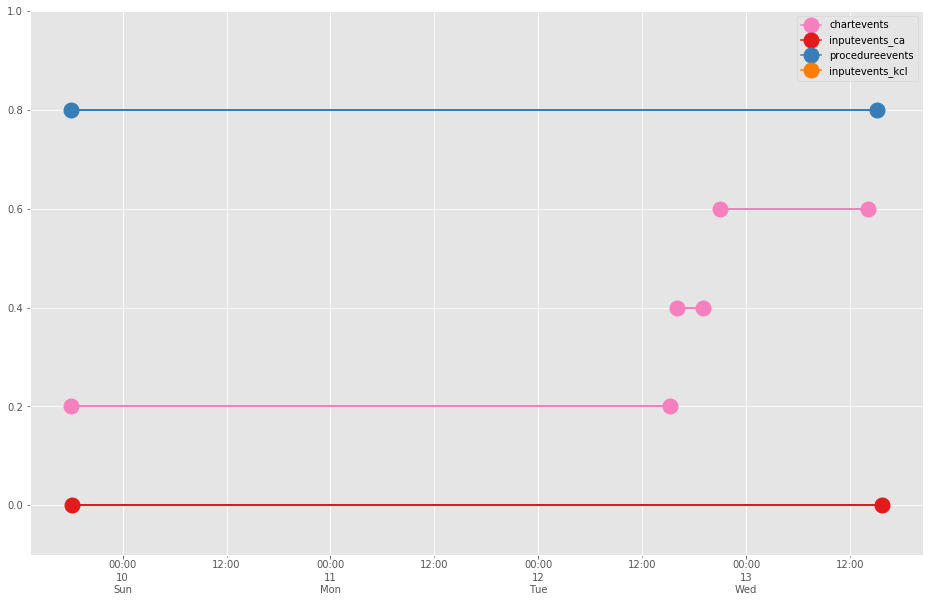

In [38]:
# how many PROCEDUREEVENTS_MV dialysis events encapsulate CHARTEVENTS/INPUTEVENTS_MV?
# vice-versa?
iid = 205508

# compare the above durations
ce['source'] = 'chartevents'
ie['source'] = 'inputevents_kcl'
ie.loc[ie['label']=='Calcium','source'] = 'inputevents_ca' 
pe['source'] = 'procedureevents'
df = pd.concat([ie[['icustay_id','num','starttime','endtime','source']], ce, pe])
idxDisplay = df['icustay_id'] == iid
display_df(df.loc[idxDisplay, :])

# 2) how many have no overlap whatsoever?


col_dict = {'chartevents': [247,129,191],
           'inputevents_kcl': [255,127,0],
           'inputevents_ca': [228,26,28],
           'procedureevents': [55,126,184]}

for c in col_dict:
    col_dict[c] = [x/256.0 for x in col_dict[c]]


fig, ax = plt.subplots(figsize=[16,10])
m = 0.
M = np.sum(idxDisplay)

# dummy plots for legend
legend_handle = list()
for c in col_dict:
    legend_handle.append(mlines.Line2D([], [], color=col_dict[c], marker='o',
                              markersize=15, label=c))

for row in df.loc[idxDisplay,:].iterrows():
    # row is a tuple: [index, actual_data], so we use row[1]
    plt.plot([row[1]['starttime'].to_pydatetime(), row[1]['endtime'].to_pydatetime()], [0+m/M,0+m/M],
            'o-',color=col_dict[row[1]['source']],
            markersize=15, linewidth=2)
    m=m+1
    
ax.xaxis.set_minor_locator(dates.HourLocator(byhour=[0,12],interval=1))
ax.xaxis.set_minor_formatter(dates.DateFormatter('%H:%M'))
ax.xaxis.grid(True, which="minor")
ax.xaxis.set_major_locator(dates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(dates.DateFormatter('\n%d\n%a'))

ax.set_ylim([-0.1,1.0])

plt.legend(handles=legend_handle,loc='best')
plt.show()

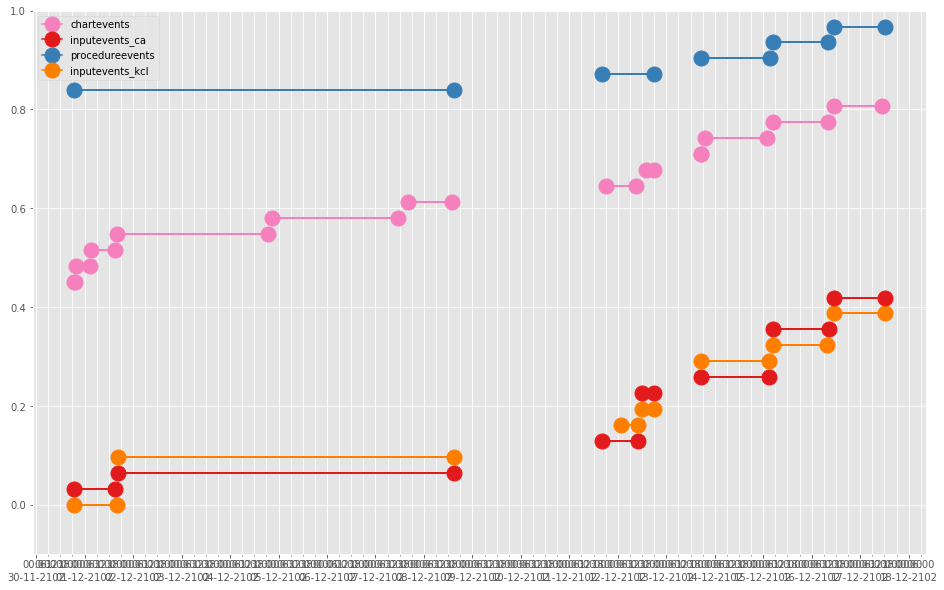

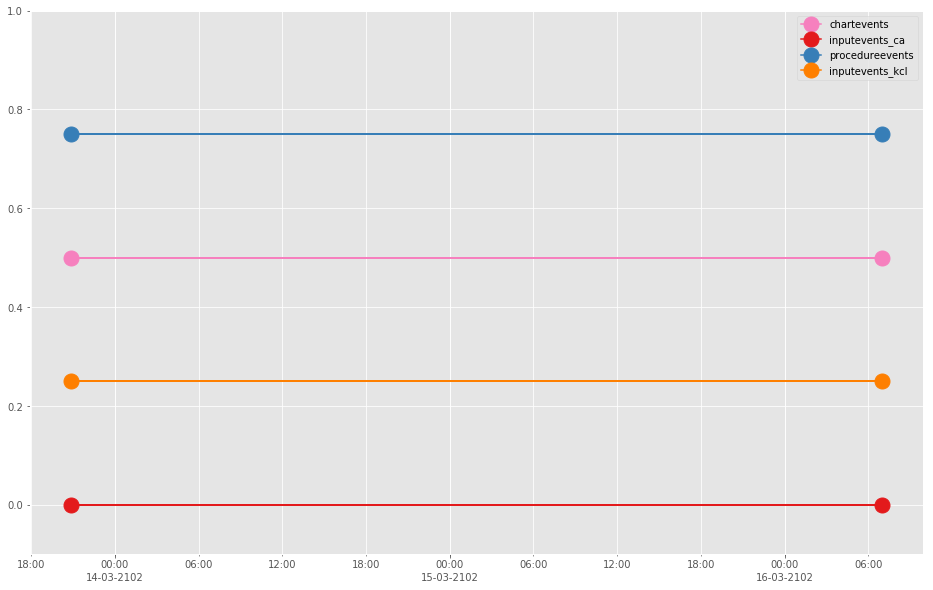

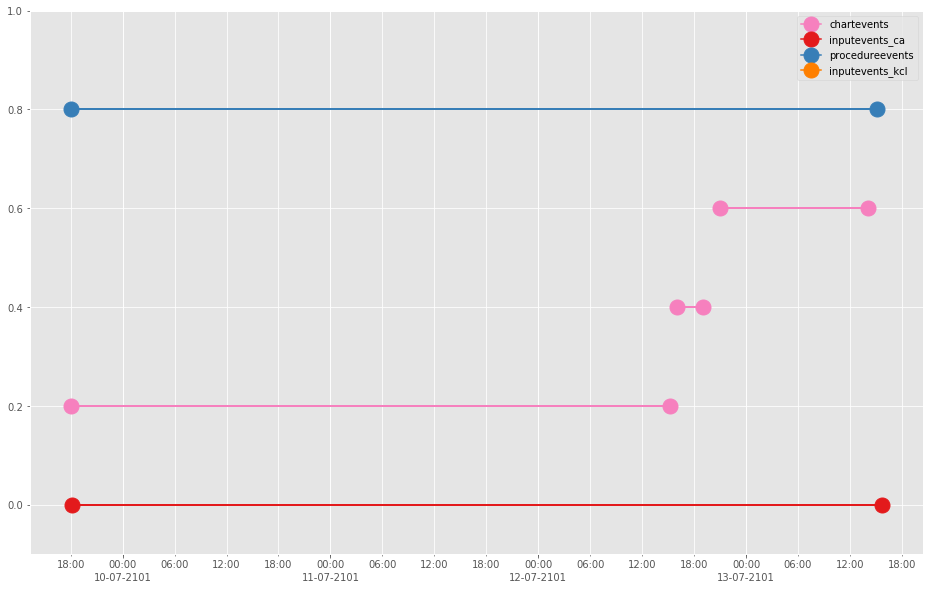

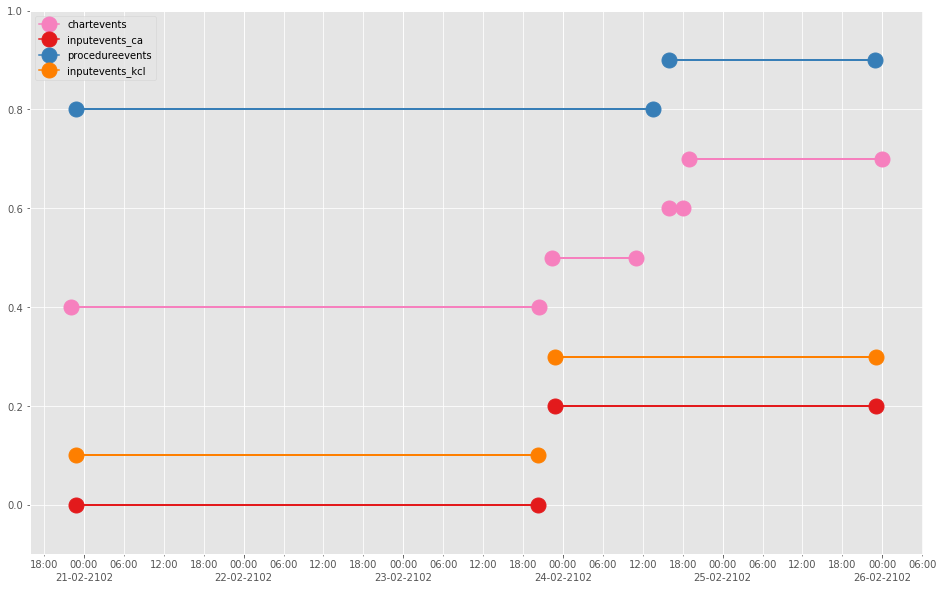

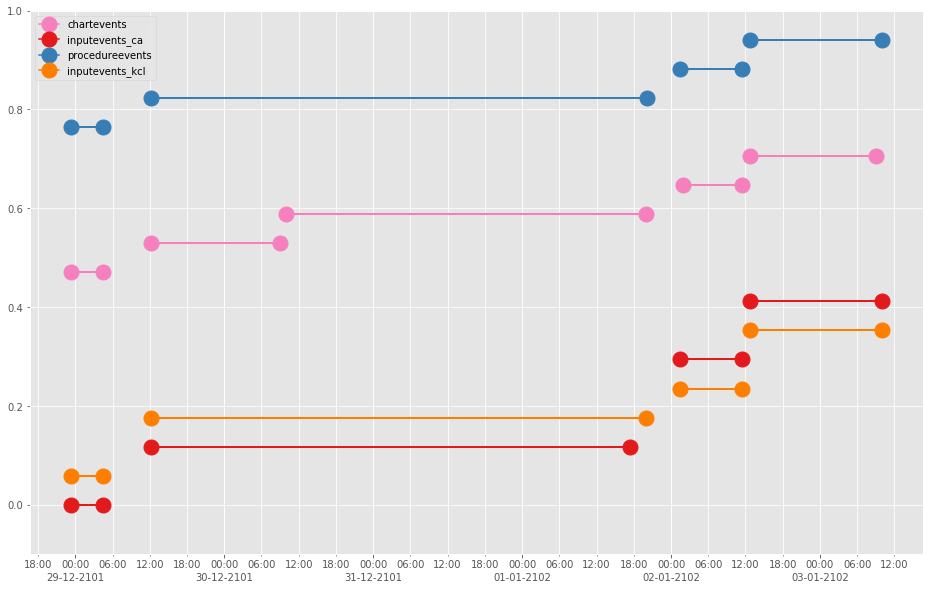

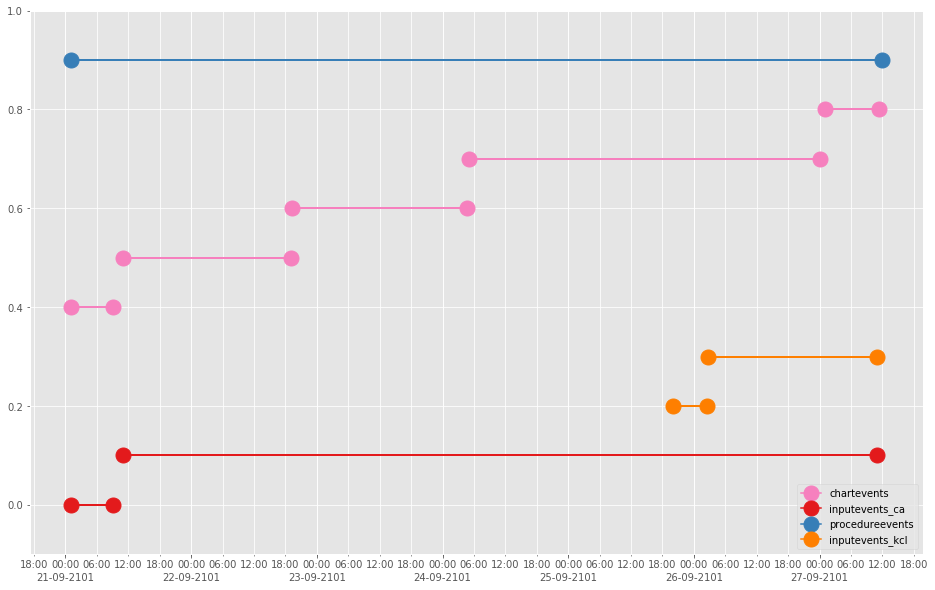

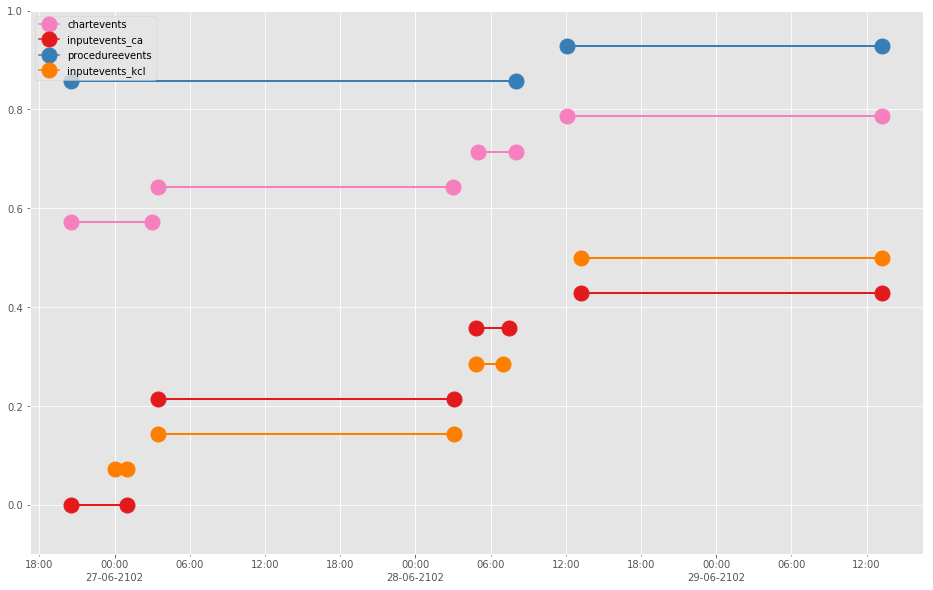

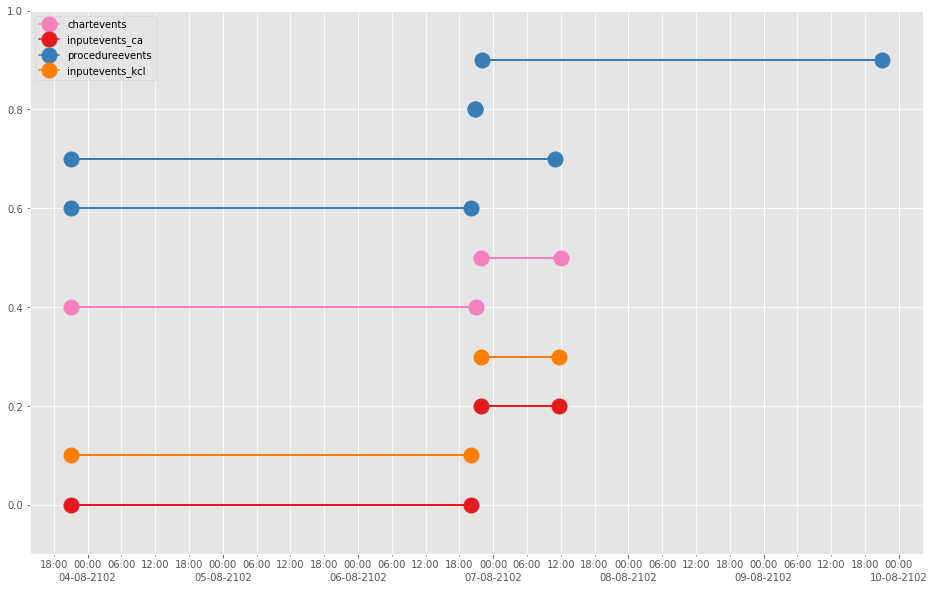

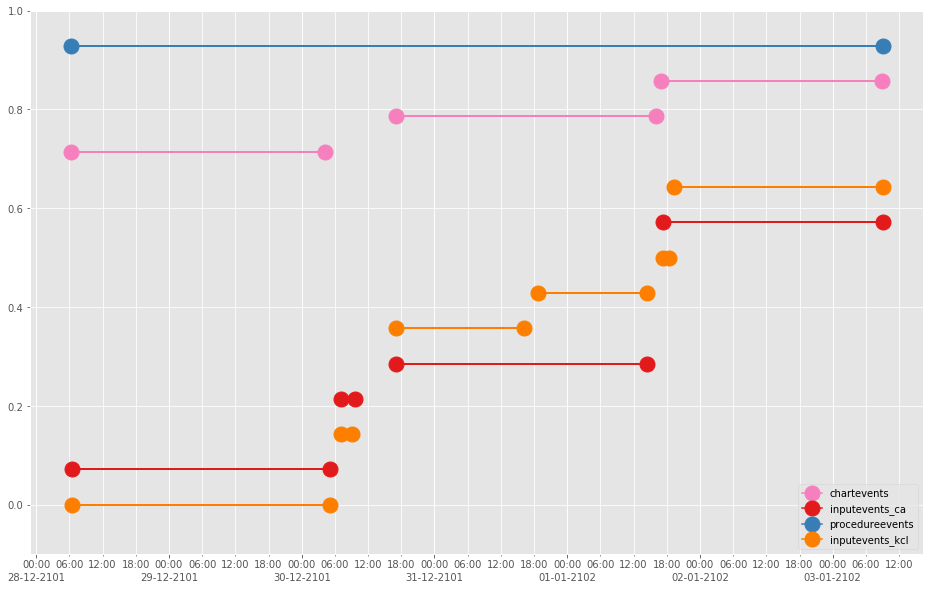

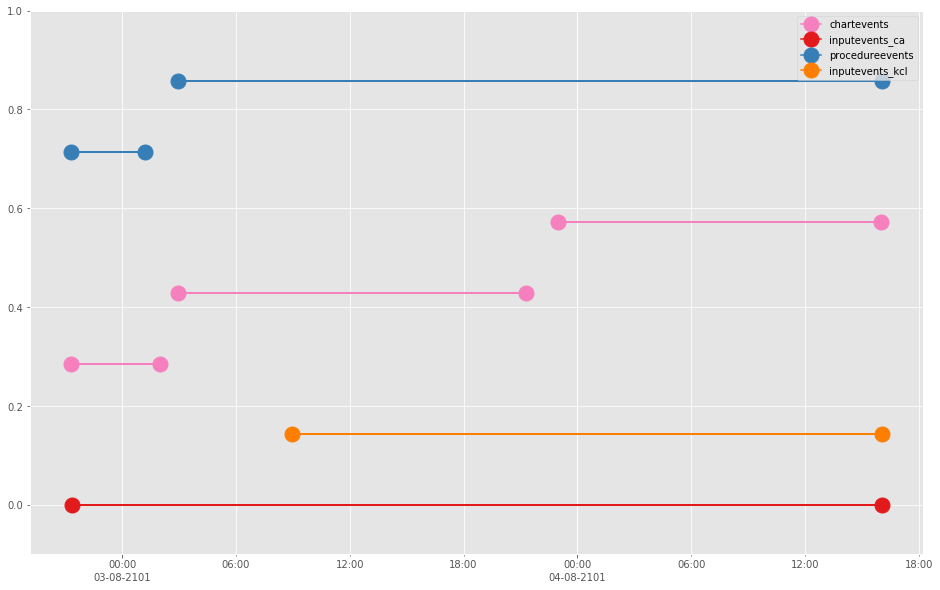

In [40]:
# print out the above for 10 examples

# compare the above durations
ce['source'] = 'chartevents'
ie['source'] = 'inputevents_kcl'
ie.loc[ie['label']=='Calcium','source'] = 'inputevents_ca' 
pe['source'] = 'procedureevents'
df = pd.concat([ie[['icustay_id','num','starttime','endtime','source']], ce, pe])

for iid in np.sort(df.icustay_id.unique()[0:10]):
    iid = int(iid)
    # how many PROCEDUREEVENTS_MV dialysis events encapsulate CHARTEVENTS/INPUTEVENTS_MV?
    # vice-versa?
    idxDisplay = df['icustay_id'] == iid
    
    # no need to display here
    #display_df(df.loc[idxDisplay, :])
    
    # 2) how many have no overlap whatsoever?
    col_dict = {'chartevents': [247,129,191],
               'inputevents_kcl': [255,127,0],
               'inputevents_ca': [228,26,28],
               'procedureevents': [55,126,184]}

    for c in col_dict:
        col_dict[c] = [x/256.0 for x in col_dict[c]]


    fig, ax = plt.subplots(figsize=[16,10])
    m = 0.
    M = np.sum(idxDisplay)

    # dummy plots for legend
    legend_handle = list()
    for c in col_dict:
        legend_handle.append(mlines.Line2D([], [], color=col_dict[c], marker='o',
                                  markersize=15, label=c))

    for row in df.loc[idxDisplay,:].iterrows():
        # row is a tuple: [index, actual_data], so we use row[1]
        plt.plot([row[1]['starttime'].to_pydatetime(), row[1]['endtime'].to_pydatetime()], [0+m/M,0+m/M],
                'o-',color=col_dict[row[1]['source']],
                markersize=15, linewidth=2)
        m=m+1

    ax.xaxis.set_minor_locator(dates.HourLocator(byhour=[0,6,12,18],interval=1))
    ax.xaxis.set_minor_formatter(dates.DateFormatter('%H:%M'))
    ax.xaxis.grid(True, which="minor")
    ax.xaxis.set_major_locator(dates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(dates.DateFormatter('\n%d-%m-%Y'))

    ax.set_ylim([-0.1,1.0])

    plt.legend(handles=legend_handle,loc='best')
    
    # if you want to save the figures, uncomment the line below
    #plt.savefig('crrt_' + str(iid) + '.png')

Examining the plots, it appears that durations from INPUTEVENTS and PROCEDUREEVENTS_MV are redundant to that in CHARTEVENTS. Furthermore, the durations from CHARTEVENTS appear to better reflect small interruptions due to clotted lines and paused treatment. As a result, we only use the durations from the CHARTEVENTS. The `concepts/durations/crrt-durations.sql` query contains the final duration query which additionally has `itemid` from CareVue. These `itemid` were determined in a similar manner to the above.